In [ ]:
!rm -rf rl_with_latents/

In [1]:
!git clone <REMOVED FOR ANONYMIZATION>

Cloning into 'rl_with_latents'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 110 (delta 46), reused 92 (delta 28), pack-reused 0
Receiving objects: 100% (110/110), 28.00 MiB | 34.58 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [2]:
!pip install -r ./rl_with_latents/requirements.txt

     |████████████████████████████████| 88.7MB 91kB/s 


In [3]:
!ls ./rl_with_latents/results

exp_model_exp_static_rnd_none_origcam_32_14999.pth
exp_model_exp_static_rnd_none_origcam_32_19999.pth
exp_model_exp_static_rnd_none_origcam_32_4999.pth
exp_model_exp_static_rnd_none_origcam_32_9999.pth
exp_model_static_rnd_color_origcam_na_990_12499.pth
exp_model_static_rnd_color_origcam_na_990_14999.pth
exp_model_static_rnd_color_origcam_na_990_17499.pth
exp_model_static_rnd_color_origcam_na_990_19999.pth
exp_model_static_rnd_color_origcam_na_990_22499.pth
exp_model_static_rnd_color_origcam_na_990_24999.pth
exp_model_static_rnd_color_origcam_na_990_2499.pth
exp_model_static_rnd_color_origcam_na_990_4999.pth
exp_model_static_rnd_color_origcam_na_990_7499.pth
exp_model_static_rnd_color_origcam_na_990_9999.pth
exp_model_static_static_color_origcam_na_1119_12499.pth
exp_model_static_static_color_origcam_na_1119_14999.pth
exp_model_static_static_color_origcam_na_1119_17499.pth
exp_model_static_static_color_origcam_na_1119_19999.pth
exp_model_static_static_color_origcam_na_1119_22499.pth
ex

In [4]:
!ls ./rl_with_latents/models

encoders.py		 vae_static_16.pth  vae_static_8.pth
__init__.py		 vae_static_32.pth  vae_static_rnd_32.pth
stdim_static_rnd_32.pth  vae_static_64.pth  vae_static_rnd_down_32.pth


In [5]:
from rl_with_latents.environments.kuka import KukaEnv
from rl_with_latents.models.encoders import VAE, NatureCNN
from rl_with_latents.utils import DotDict
from rl_with_latents.models import PolicyFC, PolicyCNN

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [202]:
env = KukaEnv(
    images=True, static_all=True, is_discrete=True, static_obj_rnd_pos=False,
    rnd_obj_rnd_pos=False, renders=False, full_color=True
)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [203]:
Z_DIMS = 32

vae = VAE(Z_DIMS)

# This model was originally trained using a GPU. The saved model weights carries
# this meta-data. The following block will allow the weights to be loaded
# even if this notebook is attached to a CPU-only machine
if torch.cuda.is_available():
  vae.load_state_dict(torch.load(f'rl_with_latents/models/vae_static_32.pth'))
else:
  vae.load_state_dict(
      torch.load(f'rl_with_latents/models/vae_static_32.pth',
                 map_location=torch.device('cpu'))
  )

In [204]:
# For whatever reason, sometimes there is a CUDA bug in PyTorch. 
# Some random seeds make the PolicyCNN network output the same tensor
# even when different tensors are inputted. Manually doing the math produces
# the correct result. Maybe something is getting cached inappropriately?
# Either way, the below seeds do not seem to have that problem.
seeds = [21390, 1235, 99663, 123555]
# 1256
torch.manual_seed(990)

model = PolicyFC(Z_DIMS)

if torch.cuda.is_available():
  model.load_state_dict(torch.load(f'rl_with_latents/results/model_static_static_none_origcam_32_2022.pth'))
else:
  model.load_state_dict(torch.load(f'rl_with_latents/results/model_static_static_none_origcam_32_2022.pth',
                                   map_location=torch.device('cpu')))
  
# This plotting model is used for the PolicyFC when plotting for experiments that track progress
plotting_model = PolicyFC(Z_DIMS)
if torch.cuda.is_available():
  plotting_model.load_state_dict(torch.load(f'rl_with_latents/results/exp_static_static_32_10000.pth'))
else:
  plotting_model.load_state_dict(torch.load(f'rl_with_latents/results/exp_static_static_32_10000.pth',
                                   map_location=torch.device('cpu')))


"""By default, Linear layers use Kaiming He Uniform initialization: https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L86
  Let's try some others:
  (a) Kaiming Normal
  (b) Drawn from a long-tail distribution
  (c) Orthogonal - DONE
"""

model_rnd = PolicyFC(Z_DIMS)

# This was for loading some custom random weights into model_rnd's layers
# model_rnd.affine1.weight.data = torch.tensor(np.random.beta(0.5, 0.5, (model_rnd.affine1.weight.data.shape[0], model_rnd.affine1.weight.data.shape[1]))).float()
# model_rnd.affine2.weight.data = torch.tensor(np.random.beta(0.5, 0.5, (model_rnd.affine2.weight.data.shape[0], model_rnd.affine2.weight.data.shape[1]))).float()


model_cnn = PolicyCNN()
if torch.cuda.is_available():
  model_cnn.load_state_dict(torch.load(f'./rl_with_latents/results/exp_model_static_static_color_origcam_na_1119_14999.pth'))
else:
  model_cnn.load_state_dict(torch.load(f'./rl_with_latents/results/exp_model_static_static_color_origcam_na_1119_14999.pth',
                                   map_location=torch.device('cpu')))
  
model_cnn_rnd = PolicyCNN()

# some weird determinism??
# model_cnn_rnd.c3.bias = None

In [205]:
states = []
latents = []
hidden_space = []
hidden_space_plotting = []
hidden_space_cnn = []
hidden_space_rnd = []
hidden_space_rnd_cnn = []
rewards = []
picked_ups = []

N_EPS = 3

n_eps_success = 0

# for _ in range(N_EPS):
while n_eps_success != N_EPS:
  inner_states = []
  inner_latents = []
  inner_hidden_space = []
  inner_hidden_space_plotting = []
  inner_hidden_space_cnn = []
  inner_hidden_space_rnd = []
  inner_hidden_space_rnd_cnn = []
  inner_rewards = []
  inner_picked_ups = []

  s = env.reset()
  # inner_states.append(s)

  # s = vae.encode_state(torch.tensor(np.moveaxis(s, -1, 0), dtype=torch.float).unsqueeze(0))
  # inner_latents.append(s.detach().numpy()[0])

  done = 0

  while not done:

    inner_states.append(s)

    # CNN STEPS (1) TRAINED CNN and then (2) RANDOM CNN
    one = F.relu(model_cnn.c1(torch.tensor(np.moveaxis(s, -1, 0), dtype=torch.float).unsqueeze(0)))
    two = F.relu(model_cnn.c2(one))
    three = F.relu(model_cnn.c3(two))
    four = model_cnn.d1(three.view(three.size(0), -1)).detach().numpy()[0]
    inner_hidden_space_cnn.append(four)

    one = F.relu(model_cnn_rnd.c1(torch.tensor(np.moveaxis(s, -1, 0), dtype=torch.float).unsqueeze(0)))
    two = F.relu(model_cnn_rnd.c2(one))
    three = F.relu(model_cnn_rnd.c3(two))
    four = F.relu(model_cnn_rnd.d1(three.view(three.size(0), -1))).detach().numpy()[0]
    inner_hidden_space_rnd_cnn.append(four)

    s = vae.encode_state(torch.tensor(np.moveaxis(s, -1, 0), dtype=torch.float).unsqueeze(0))
    inner_latents.append(s.detach().numpy()[0])
    a_probs, v = model(s)
    a = torch.argmax(a_probs).item()

    inner_hidden_space.append(model.affine2(F.relu(model.affine1(s))).detach().numpy()[0])
    inner_hidden_space_rnd.append(model_rnd.affine2(F.relu(model_rnd.affine1(s))).detach().numpy()[0])
    inner_hidden_space_plotting.append(plotting_model.affine2(F.relu(plotting_model.affine1(s))).detach().numpy()[0])
    s, reward, picked_up, done, _ = env.step(a)

    inner_rewards.append(reward)
    inner_picked_ups.append(picked_up)

    if picked_up:
      done = True

    # Confused on why this needs to be here...?
    if done:
      break
   
  if picked_up:
    states.append(inner_states)
    latents.append(inner_latents)
    hidden_space.append(inner_hidden_space)
    hidden_space_plotting.append(inner_hidden_space_plotting)
    hidden_space_cnn.append(inner_hidden_space_cnn)
    hidden_space_rnd.append(inner_hidden_space_rnd)
    hidden_space_rnd_cnn.append(inner_hidden_space_rnd_cnn)
    rewards.append(inner_rewards)
    picked_ups.append(inner_picked_ups)

    n_eps_success += 1
  else:
    print('Trying again...')
    continue

Successfully grasped a block!
Successfully grasped a block!
Successfully grasped a block!


In [206]:
flattened_states = [[x.flatten() for x in s] for s in states]

In [207]:
# To cut down on the compute, we sample 100 states from each episode, plus the success state
flattened_states_samples = []
latents_samples = []
hidden_space_samples = []
hidden_space_plotting_samples = []
hidden_space_cnn_samples = []
hidden_space_rnd_samples = []
hidden_space_rnd_cnn_samples = []
rewards_samples = []
picked_ups_samples = []

for i in range(N_EPS):
  idxs = np.random.choice([x for x in range(450)], 250, replace=False)

  samples = (np.array(flattened_states[i])[idxs]).tolist()
  samples.append(flattened_states[i][-1].tolist())
  [flattened_states_samples.append(x) for x in samples]

  samples = (np.array(latents[i])[idxs]).tolist()
  samples.append(latents[i][-1].tolist())
  [latents_samples.append(x) for x in samples]

  samples = (np.array(hidden_space[i])[idxs]).tolist()
  samples.append(hidden_space[i][-1].tolist())
  [hidden_space_samples.append(x) for x in samples]

  samples = (np.array(hidden_space_plotting[i])[idxs]).tolist()
  samples.append(hidden_space_plotting[i][-1].tolist())
  [hidden_space_plotting_samples.append(x) for x in samples]

  samples = (np.array(hidden_space_cnn[i])[idxs]).tolist()
  samples.append(hidden_space_cnn[i][-1].tolist())
  [hidden_space_cnn_samples.append(x) for x in samples]

  samples = (np.array(hidden_space_rnd[i])[idxs]).tolist()
  samples.append(hidden_space_rnd[i][-1].tolist())
  [hidden_space_rnd_samples.append(x) for x in samples]

  samples = (np.array(hidden_space_rnd_cnn[i])[idxs]).tolist()
  samples.append(hidden_space_rnd_cnn[i][-1].tolist())
  [hidden_space_rnd_cnn_samples.append(x) for x in samples]

  samples = (np.array(rewards[i])[idxs]).tolist()
  samples.append(rewards[i][-1])
  [rewards_samples.append(x) for x in samples]

  samples = (np.array(picked_ups[i])[idxs]).tolist()
  samples.append(picked_ups[i][-1])
  [picked_ups_samples.append(x) for x in samples]


In [208]:
# Generating random numbers for a control test! SKIP!

rnd_img = []
rnd_latent = []

for i in range(len(flattened_states_samples)):
  rnd_img.append(np.reshape(np.random.rand(150528), (224, 224, 3)))
  rnd_latent.append(np.random.rand(32))

# Now running them through the models to get the output
rnd_img_hidden = []
rnd_latent_hidden = []

for i in range(len(flattened_states_samples)):
  s = torch.tensor(rnd_latent[i], dtype=torch.float).unsqueeze(0)
  rnd_latent_hidden.append(model.affine2(F.relu(model.affine1(s))).detach().numpy()[0])

  s = torch.tensor(np.moveaxis(rnd_img[i], -1, 0), dtype=torch.float).unsqueeze(0)
  one = F.relu(model_cnn.c1(s))
  two = F.relu(model_cnn.c2(one))
  three = F.relu(model_cnn.c3(two))
  four = F.relu(model_cnn.d1(three.view(three.size(0), -1))).detach().numpy()[0]
  rnd_img_hidden.append(four)

In [209]:
# this is to help with the viz - otherwise the color gradient is u|gly
scaled_rewards_samples = [x if x < 10 else 1 for x in rewards_samples]

PCA

In [211]:
pca_full = PCA(2)
pca_latent = PCA(3)
pca_hidden = PCA(3)
pca_hidden_plotting = PCA(3)
pca_hidden_cnn = PCA(3)
pca_hidden_rnd = PCA(3)
pca_hidden_rnd_cnn = PCA(3)

pca_noisy_cnn = PCA(3)
pca_noise_latent = PCA(3)

In [212]:
# out_full = pca_full.fit_transform(np.array(flattened_states_samples))
out_latents = pca_latent.fit_transform(np.array(latents_samples))
out_hidden = pca_hidden.fit_transform(np.array(hidden_space_samples))
out_hidden_plotting = pca_hidden_plotting.fit_transform(np.array(hidden_space_plotting_samples))
out_hidden_cnn = pca_hidden_cnn.fit_transform(np.array(hidden_space_cnn_samples))
out_hidden_rnd = pca_hidden_rnd.fit_transform(np.array(hidden_space_rnd_samples))
out_hidden_rnd_cnn = pca_hidden_rnd_cnn.fit_transform(np.array(hidden_space_rnd_cnn_samples))

# out_noisy_cnn = pca_noisy_cnn.fit_transform(rnd_img_hidden)
out_noisy_latent = pca_noise_latent.fit_transform(rnd_latent_hidden)

In [213]:
import pickle

# with open('./pca_trained_latent.data', 'wb') as f:
#   pickle.dump(out_hidden, f)

# with open('./pca_random_latent.data', 'wb') as f:
#   pickle.dump(out_hidden_rnd, f)

# with open('./pca_trained_images.data', 'wb') as f:
#   pickle.dump(out_hidden_cnn, f)

with open('./pca_exp_ssl_10000.data', 'wb') as f:
  pickle.dump(out_hidden_plotting, f)

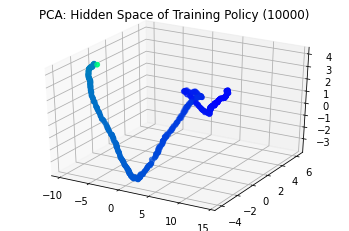

In [214]:
# PLOTTING EXPERIMENTS
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# ax.set_xticks(np.linspace(-0.0075,  0.0125, 5).tolist())
# ax.set_yticks(np.linspace(-0.006,  0.008, 5).tolist())
# ax.set_zticks(np.linspace())

plt.title('PCA: Hidden Space of Training Policy (10000)')
ax.scatter(out_hidden_plotting[:, 0], out_hidden_plotting[:, 1], out_hidden_plotting[:, 2], c=scaled_rewards_samples, cmap='winter')
plt.savefig('./pca_exp_ssl_10000.png', dpi=400)

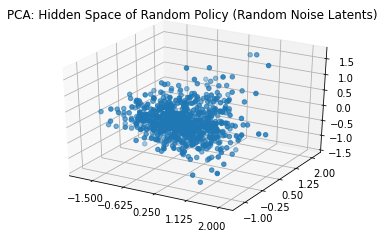

In [199]:
# PLOTTING EXPERIMENTS
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xticks(np.linspace(-1.5,  2.0, 5).tolist())
ax.set_yticks(np.linspace(-1., 2., 5).tolist())
# ax.set_zticks(np.linspace())

plt.title('PCA: Hidden Space of Random Policy (Random Noise Latents)')
ax.scatter(out_noisy_latent[:, 0], out_noisy_latent[:, 1], out_noisy_latent[:, 2])
plt.savefig('./noisy_latents.png', dpi=400)

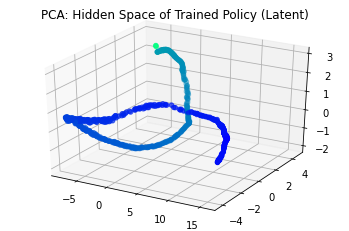

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title('PCA: Hidden Space of Trained Policy (Latent)')
ax.scatter(out_hidden[:, 0], out_hidden[:, 1], out_hidden[:, 2], c=scaled_rewards_samples, cmap='winter')
plt.savefig('./pca_trained_latent.png', dpi=400)

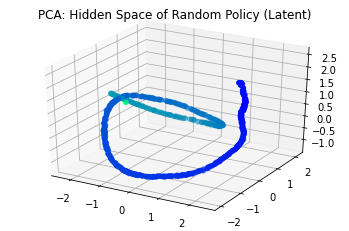

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title('PCA: Hidden Space of Random Policy (Latent)')
ax.scatter(out_hidden_rnd[:, 0], out_hidden_rnd[:, 1], out_hidden_rnd[:, 2], c=scaled_rewards_samples, cmap='winter')
plt.savefig('./pca_random_latent.png', dpi=400)

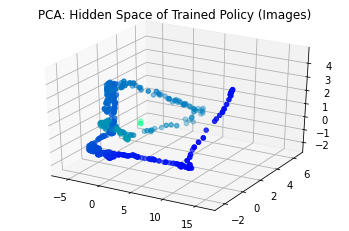

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title('PCA: Hidden Space of Trained Policy (Images)')
ax.scatter(out_hidden_cnn[:, 0], out_hidden_cnn[:, 1], out_hidden_cnn[:, 2], c=scaled_rewards_samples, cmap='winter')
plt.savefig('./pca_trained_full.png', dpi=400)

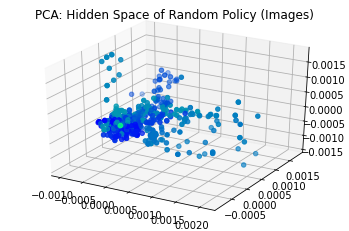

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title('PCA: Hidden Space of Random Policy (Images)')
ax.scatter(out_hidden_rnd_cnn[:, 0], out_hidden_rnd_cnn[:, 1], out_hidden_rnd_cnn[:, 2], c=scaled_rewards_samples, cmap='winter')
plt.savefig('./pca_random_full.png', dpi=400)